## 2024 Spotify Wrapped Analysis
Author: Joe Muscolino

Last Updated: 12/30/2024

In [1]:
import pandas as pd
import json 
from datetime import datetime
import seaborn as sn

# Open My Spotify Listening data
music1 = pd.read_json("StreamingHistory_music_0.json")
music2 = pd.read_json("StreamingHistory_music_1.json")
music3 = pd.read_json("StreamingHistory_music_2.json")
frames = [music1, music2, music3]

# Pull together various JSON files into one DataFrame
music = pd.concat(frames)
music.head(5)

,endTime,artistName,trackName,msPlayed
0,2023-12-05 22:21,Sade,Paradise,85008
1,2023-12-06 00:08,Alice In Chains,Nutshell,77188
2,2023-12-06 00:16,Mitski,My Love Mine All Mine,137773
3,2023-12-06 00:19,TV Girl,Lovers Rock,213920
4,2023-12-06 00:22,Eslabon Armado,Ella Baila Sola,165671


In [3]:
# Open dataset of artists information found on Kaggle. 
# We will join this table with my Spotify listening data in order to pull in Artist genre's which aren't included in the Spotify dataset.
artists_data_set = pd.read_csv("artists.csv", dtype={"tags_lastfm":'string',"country_lastfm":'string',"artist_lastfm":'string',
                                                     "mbid":'string', "listeners_lastfm":'string', "scrobbles_lastfm":'string'})
# Using .info() we can view a brief summary of the dataset columns.
artists_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466083 entries, 0 to 1466082
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   mbid              1466083 non-null  string
 1   artist_mb         1466075 non-null  object
 2   artist_lastfm     986756 non-null   string
 3   country_mb        662368 non-null   object
 4   country_lastfm    211498 non-null   string
 5   tags_mb           119946 non-null   object
 6   tags_lastfm       381075 non-null   string
 7   listeners_lastfm  986760 non-null   string
 8   scrobbles_lastfm  986760 non-null   string
 9   ambiguous_artist  1466083 non-null  bool  
dtypes: bool(1), object(3), string(6)
memory usage: 102.1+ MB


In [5]:
# Before doing anything else, check to see if there are duplicate artists in the dataset. 
# If there are duplicates, we want to remove them to avoid any issues when we merge this DataFrame with the Spotify data.
print(f'Total Artist Count: {len(artists_data_set["artist_mb"])}\nDistinct Artist Count: {len(artists_data_set["artist_mb"].unique())}')

Total Artist Count: 1466083
Distinct Artist Count: 1352997


In [6]:
# Since we found duplicates, drop duplicate artists and remove rows missing an artist name or artist tags.
artists_data_set = artists_data_set.drop_duplicates(subset="artist_mb")
# Drop rows missing values
artists_data_set.dropna(subset="artist_mb", inplace=True)
artists_data_set.dropna(subset="tags_lastfm", inplace=True)
# Create a copy of our original DataFrame which only contains the columns: artist_mb, tags_lastfm 
artists_info = artists_data_set[["artist_mb","tags_lastfm"]].copy()
artists_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354668 entries, 0 to 986758
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   artist_mb    354668 non-null  object
 1   tags_lastfm  354668 non-null  string
dtypes: object(1), string(1)
memory usage: 8.1+ MB


### Merge DataFrames
Now that we have the data we want, our next step will be to merge our two DataFrames together. Once merged, we will add a few additional columns 
that will help simplify our analysis later on. 

In [7]:
# Merge artist and music tables
music_w_genres = music.merge(artists_info, how='left', left_on="artistName", right_on="artist_mb")
# Add columns for seconds, minutes, and hours of songs played
music_w_genres["sPlayed"] = music_w_genres["msPlayed"] / 1000
music_w_genres["minsPlayed"] = round(music_w_genres["sPlayed"] / 60,3)
music_w_genres["hoursPlayed"] = round(music_w_genres["minsPlayed"] / 60, 3)
# For any of the artists who didn't have a match when merging our DataFrames, replace the missing values in column tags_lastfm with None.
music_w_genres["tags_lastfm"].fillna("None", inplace = True)
music_w_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24408 entries, 0 to 24407
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   endTime      24408 non-null  object 
 1   artistName   24408 non-null  object 
 2   trackName    24408 non-null  object 
 3   msPlayed     24408 non-null  int64  
 4   artist_mb    11168 non-null  object 
 5   tags_lastfm  24408 non-null  string 
 6   sPlayed      24408 non-null  float64
 7   minsPlayed   24408 non-null  float64
 8   hoursPlayed  24408 non-null  float64
dtypes: float64(3), int64(1), object(4), string(1)
memory usage: 1.9+ MB


In [8]:
# Next, I want to remove certain artists who I only listen to while I'm working. These artists comprise a large amount of my total listening time,
# but are only played in the background while I work. It would be misleading to keep these artists in the analysis as they would appear as being my 
# top artists, when in reality they are not. 
classical_artists = ["Ludwig van Beethoven","Frédéric Chopin","Samuel Barber","Claude Debussy","Antonín Dvořák","dj poolboi",
                     "Wolfgang Amadeus Mozart","Carl Loewe", "Franz Liszt","Johann Sebastian Bach"]
music_final = music_w_genres[~music_w_genres["artistName"].isin(classical_artists)].copy()

In [9]:
# Lastly, we will add a new column called: genre. Currently, our column tags_lastfm contains a list of the various genres that our artists fall into.
# Since many artists fall into multiple genres, each row contains multiple genre values, but for the sake of analyzing our data, we'd like a column containing their
# primary genre. To do this, we will parse the column tags_lstfm and extract the first element in each list. 

genre_lis = []
for tag in music_final["tags_lastfm"]:
    # Split the string value into a list of values.
    tag = tag.split(";")
    # Assign the genre value at Index 0 to a new variable.
    genre = tag[0]
    # Add the genre to our list.
    genre_lis.append(genre)

music_final["genre"] = genre_lis.copy()
music_final.head(15)

,endTime,artistName,trackName,msPlayed,artist_mb,tags_lastfm,sPlayed,minsPlayed,hoursPlayed,genre
0,2023-12-05 22:21,Sade,Paradise,85008,Sade,soul; female vocalists; jazz; chillout; pop; S...,85.008,1.417,0.024,soul
1,2023-12-06 00:08,Alice In Chains,Nutshell,77188,NaN,None,77.188,1.286,0.021,None
2,2023-12-06 00:16,Mitski,My Love Mine All Mine,137773,Mitski,seen live; indie rock; indie; dream pop; indie...,137.773,2.296,0.038,seen live
3,2023-12-06 00:19,TV Girl,Lovers Rock,213920,TV Girl,Lo-Fi; indie; chillwave; indie pop; pop; san d...,213.920,3.565,0.059,Lo-Fi
4,2023-12-06 00:22,Eslabon Armado,Ella Baila Sola,165671,NaN,None,165.671,2.761,0.046,None
5,2023-12-06 00:27,Black Sabbath,Changes - 2013 Remaster,282497,Black Sabbath,heavy metal; hard rock; classic rock; metal; r...,282.497,4.708,0.078,heavy metal
6,2023-12-06 01:11,Cigarettes After Sex,K.,320030,Cigarettes After Sex,dream pop; shoegaze; seen live; slowcore; Lo-F...,320.030,5.334,0.089,dream pop
7,2023-12-06 01:14,Vacations,Young,189160,NaN,None,189.160,3.153,0.053,None
8,2023-12-06 01:16,Delaney Bailey,j's lullaby (darlin' i'd wait for you),119824,NaN,None,119.824,1.997,0.033,None
9,2023-12-06 01:16,Steve Lacy,Bad Habit,1557,Steve Lacy,free jazz; jazz; saxophone; Avant-Garde Jazz; ...,1.557,0.026,0.000,free jazz


In [22]:
# Export table to CSV for use within Tableau
# music_final.to_csv("spotfiyListeningHistory_2.csv")
# music_final.head()

,endTime,artistName,trackName,msPlayed,artist_mb,tags_lastfm,sPlayed,minsPlayed,hoursPlayed,genre
0,2023-12-05 22:21,Sade,Paradise,85008,Sade,soul; female vocalists; jazz; chillout; pop; S...,85.008,1.417,0.024,soul
1,2023-12-06 00:08,Alice In Chains,Nutshell,77188,NaN,None,77.188,1.286,0.021,None
2,2023-12-06 00:16,Mitski,My Love Mine All Mine,137773,Mitski,seen live; indie rock; indie; dream pop; indie...,137.773,2.296,0.038,seen live
3,2023-12-06 00:19,TV Girl,Lovers Rock,213920,TV Girl,Lo-Fi; indie; chillwave; indie pop; pop; san d...,213.920,3.565,0.059,Lo-Fi
4,2023-12-06 00:22,Eslabon Armado,Ella Baila Sola,165671,NaN,None,165.671,2.761,0.046,None


## Data Visualizations
Now that we have cleaned and modified our dataset to provide the desired data, we can begin to analyze and visualize the results.

In [10]:
from datetime import datetime
import seaborn as sn

# Group data by artist to find most listened to in terms of plays and minutes listened
artist = music_final.groupby("artistName").aggregate({'artistName':'count', 'minsPlayed':'sum'})

artist.sort_values(by="minsPlayed", ascending=False,inplace=True)
print(f'Top Artist by minutes of listening: {artist["artistName"].index[0]}')

Top Artist by minutes of listening: Lil Peep


In [8]:
# Add avg amount of time listened 
artist["avgMinsPlayed"] = round(artist["minsPlayed"] / artist["artistName"], 3)
artist.head(10)

,artistName,minsPlayed,hoursPlayed,avgMinsPlayed
artistName,,,,
Lil Peep,962,1366.1553,22.769,1.420
Swimming Paul,371,1200.9134,20.015,3.237
Oasis,348,1070.3092,17.838,3.076
blink-182,500,1049.6834,17.495,2.099
$uicideboy$,595,894.5698,14.909,1.503
Khruangbin,377,858.3696,14.306,2.277
Royel Otis,338,682.3957,11.373,2.019
Fred again..,265,572.0006,9.533,2.158
The Story So Far,314,565.1010,9.418,1.800


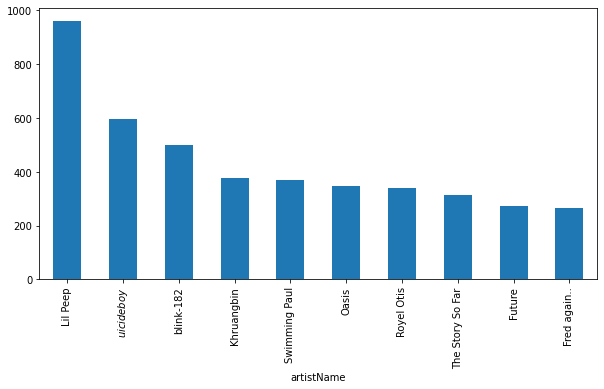

In [9]:
import matplotlib.pyplot as plt
top_by_plays = artist["artistName"].sort_values(ascending=False)

top_10_artists_by_plays = top_by_plays[:10]

plt.figure(figsize=(10,5))
top_10_artists_by_plays.plot.bar(x=top_10_artists_by_plays.index,y='artistName')
plt.show()

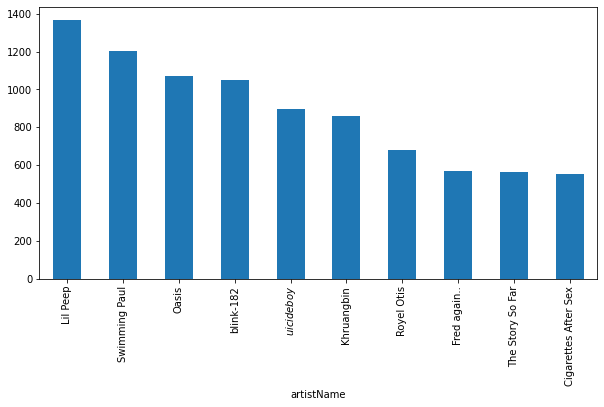

In [10]:
top_by_mins = artist["minsPlayed"].sort_values(ascending=False)

top_10_artists_by_mins = top_by_mins[:10]

plt.figure(figsize=(10,5))
top_10_artists_by_mins.plot.bar(x=top_10_artists_by_mins.index,y='minsPlayed')
plt.show()

## Time series data

In [11]:
time_series = music.copy()
time_series["listeningDate"] = pd.to_datetime(time_series["endTime"]).dt.date
time_series.head()

,endTime,artistName,trackName,msPlayed,sPlayed,minsPlayed,listeningDate
0,2023-12-05 22:21,Sade,Paradise,85008,85.008,1.4168,2023-12-05
1,2023-12-06 00:08,Alice In Chains,Nutshell,77188,77.188,1.2865,2023-12-06
2,2023-12-06 00:16,Mitski,My Love Mine All Mine,137773,137.773,2.2962,2023-12-06
3,2023-12-06 00:19,TV Girl,Lovers Rock,213920,213.920,3.5653,2023-12-06
4,2023-12-06 00:22,Eslabon Armado,Ella Baila Sola,165671,165.671,2.7612,2023-12-06


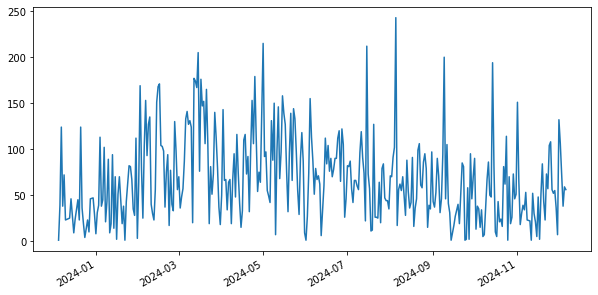

In [12]:
time_series.sort_values(by="listeningDate", inplace=True)
count_listening_dates = time_series["listeningDate"].value_counts().sort_index(ascending=True)
count_listening_dates

plt.figure(figsize=(10,5))
plt.plot(count_listening_dates)
plt.gcf().autofmt_xdate()
plt.rcParams.update({'font.size': 14})
plt.show()

In [13]:
time_series["endTime"] = pd.to_datetime(time_series["endTime"])
time_series["month_dt"] = time_series["endTime"].dt.month
time_series["month_strftime"] = time_series["endTime"].dt.strftime('%b')
time_series.head()

,endTime,artistName,trackName,msPlayed,sPlayed,minsPlayed,listeningDate,month_dt,month_strftime
0,2023-12-05 22:21:00,Sade,Paradise,85008,85.008,1.4168,2023-12-05,12,Dec
22,2023-12-06 18:42:00,Claude Debussy,"Clair de Lune, L. 32",1136,1.136,0.0189,2023-12-06,12,Dec
23,2023-12-06 19:15:00,TV Girl,Lovers Rock,213920,213.920,3.5653,2023-12-06,12,Dec
24,2023-12-06 20:35:00,Sade,Paradise,132436,132.436,2.2073,2023-12-06,12,Dec
25,2023-12-06 20:39:00,Sade,Nothing Can Come Between Us,234666,234.666,3.9111,2023-12-06,12,Dec


<Figure size 720x360 with 0 Axes>

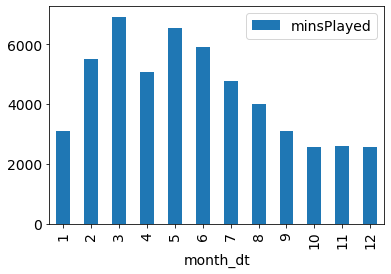

In [14]:
# Group minutes played by Month
mins_by_month = time_series.groupby("month_dt").aggregate({'minsPlayed':'sum'})
mins_by_month.sort_index(ascending=True, inplace=True)
mins_by_month
plt.figure(figsize=(10,5))
mins_by_month.plot.bar()
plt.show()